In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
import torchvision.transforms as transforms

from sklearn import datasets
import pandas as pd

import matplotlib.pyplot as plt

### 0. Gradients with PyTorch

At this point, you've implemented a lot of gradients. However, these days, manual implementation of gradients is a thing of the past: PyTorch is a scientific computing library that comes with the ability to automatically compute gradients for you! This is called auto-differentiation. Here is an example of using auto-differentiation to compute the gradient of a quadratic function, $f(x) = ax^2$. The key parts are as follows:

1. Variables that you want to differentiate with respect to should have the `requires_grad` flag set to `True`.
2. Calculate the objective that you'd like the compute the gradient of, using the variable from step (1).
3. Pass the objective and the variable you are differentiating to `torch.autograd.grad`.

In [2]:
# Step 1: Set requires_grad to True for x
x = torch.Tensor([3.0])
a = torch.Tensor([1.5])
x.requires_grad = True

# Step 2: Compute the objective
y = a * (x**2)

# Step 3: Use autograd
grad = torch.autograd.grad([y],[x])[0]

print("PyTorch gradient:", grad)
print("Manual gradient:", 2*a*x)

PyTorch gradient: tensor([9.])
Manual gradient: tensor([9.], grad_fn=<MulBackward0>)


You'll notice that the gradient computed with PyTorch matches exactly the analytic gradient $\nabla f(x) = 2ax$, but without having to implement or derive the analytic gradient! This works for gradients with respect to any sized variables. For example, if $x$ is now a vector, and the objective is $f(x) = a\|x\|_2^2$ then we can calculate the gradient in the same way:

In [3]:
# Step 1: Set requires_grad to True for x
x = torch.Tensor([3.0, 2.0])
a = torch.Tensor([1.5])
x.requires_grad = True

# Step 2: Compute the objective
y = a * (x.norm(p=2)**2)

# Step 3: Use autograd
grad = torch.autograd.grad([y],[x])[0]

print("PyTorch gradient:", grad)
print("Analytic gradient:", 2*a*x)

PyTorch gradient: tensor([9.0000, 6.0000])
Analytic gradient: tensor([9., 6.], grad_fn=<MulBackward0>)


# 1. SVM and Gradient Descent -- This time with Autograd!

In this first problem, you'll implement (soft margin) support vector machines with gradient descent, using gradients from PyTorch's autodifferentiation library.
+ (2pts) Calculate the objective of the Soft SVM
+ (2pts) Calculate the gradient of the Soft SVM objective, but using torch.autograd.grad
+ (2pts) Implement a basic gradient descent optimizer. Your solution needs to converge to an accurate enough answer.
+ (1pts) Make predictions with the Soft SVM

Tips:
- Take a look back at Homework 2 -- this problem shouldn't take you very long :-)

In [4]:
class SoftSVM:
    def __init__(self, ndims):
        # Here, we initialize the parameters of your soft-SVM model for binary
        # classification. Don't change the weight and bias variables as the
        # autograder will assume that these exist.
        # ndims := integer -- number of dimensions
        # no return type

        self.weight = torch.zeros(ndims, requires_grad=True)
        self.bias = torch.zeros(1, requires_grad=True)


    def objective(self, X, y, l2_reg):
        # Calculate the objective of your soft-SVM model
        # X := Tensor of size (m,d) -- the input features of m examples with d dimensions
        # y := Tensor of size (m) -- the labels for each example in X
        # l2_reg := float -- L2 regularization penalty
        # Returns a scalar tensor (zero dimensional tensor) -- the loss for the model
        # Fill in the rest
        m, d = X.size()

        margin = 1 - y * (X @ self.weight + self.bias)
        hinge_loss = torch.sum(torch.max(torch.zeros(m), margin))

        reg_term = l2_reg * torch.sum(self.weight ** 2)

        return hinge_loss / m + reg_term


    def gradient(self, X, y, l2_reg):
        # Calculate the gradient of your soft-SVM model
        # X := Tensor of size (m,d) -- the input features of m examples with d dimensions
        # y := Tensor of size (m) -- the labels for each example in X
        # l2_reg := float -- L2 regularization penalty
        # Return Tuple (Tensor, Tensor) -- the tensors corresponds to the weight
        # and bias parameters respectively
        # Fill in the rest
        w_grad = torch.autograd.grad([self.objective(X, y, l2_reg)], [self.weight])[0]
        b_grad = torch.autograd.grad([self.objective(X, y, l2_reg)], [self.bias])[0]

        return w_grad, b_grad


    def optimize(self, X, y, l2_reg):
        # Calculate the gradient of your soft-SVM model
        # X := Tensor of size (m,d) -- the input features of m examples with d dimensions
        # y := Tensor of size (m) -- the labels for each example in X
        # l2_reg := float -- L2 regularization penalty

        # no return type

        # Fill in the rest
        prev_objective = float('inf')
        tolerance = 1e-5
        learning_rate = 1.491
        n_iter = 0

        while True:
            n_iter += 1
            current_objective = self.objective(X, y, l2_reg)
            if current_objective < 0.16 or abs(prev_objective - current_objective) < tolerance:
                print('{} iteration(s)'.format(n_iter))
                break

            prev_objective = current_objective
            wg, bg = self.gradient(X, y, l2_reg)
            self.weight = self.weight - wg * learning_rate
            self.bias = self.bias - bg * learning_rate


    def predict(self, X):
        # Given an X, make a prediction with the SVM
        # X := Tensor of size (m,d) -- features of m examples with d dimensions
        # Return a tensor of size (m) -- the prediction labels on the dataset X
        return torch.sign(X @ self.weight + self.bias)

In [5]:
# Load Dataset
cancer = datasets.load_breast_cancer()
X, y = torch.from_numpy(cancer['data']), torch.from_numpy(cancer['target'])
mu, sigma = X.mean(0, keepdim=True), X.std(0, keepdim=True)
X, y = ((X-mu)/sigma).float(), (y-0.5).sign()
l2_reg = 0.1
print(X.size(), y.size())

# Optimize the soft-SVM with GD
clf = SoftSVM(X.size(1))
clf.optimize(X, y, l2_reg)
print("\nSoft SVM objective : {}".format(clf.objective(X, y, l2_reg).item()))
print("\nSoft SVM accuracy : {}".format((clf.predict(X) == y).float().mean().item()))

torch.Size([569, 30]) torch.Size([569])
9 iteration(s)

Soft SVM objective : 0.15944302082061768

Soft SVM accuracy : 0.9753954410552979


# Question 2: Fully Connected Neural Network (10 points)
Import MNIST dataset.

In [6]:
transformation = transforms.Compose([transforms.ToTensor(), torch.flatten])

train_set = MNIST('./data', train=True, download=True, transform=transformation)
test_set = MNIST('./data', train=False, download=True, transform=transformation)

train_loader = DataLoader(train_set, batch_size=1024, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=1024, shuffle=False, num_workers=0)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 123MB/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 6.47MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 93.4MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.47MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Check the dataset.

training set is 60000 x 784
test     set is 10000 x 784


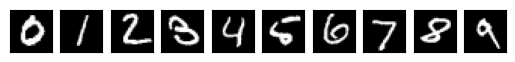

In [10]:
print("training set is {:d} x {:d}".format(60000, 28 * 28))
print("test     set is {:d} x {:d}".format(10000, 28 * 28))

fig, axes = plt.subplots(1, 10)
for i in range(10):
  target_mask = test_set.targets == i
  img = test_set.data[target_mask][0]   # Choose only the first image!
  axes[i].imshow(img, cmap='gray')
  axes[i].set_xticks([])
  axes[i].set_yticks([])
plt.show()

Implement a fully connected neural network using `torch.autograd` and `torch.nn`.

1. (4 points) Implement the `Network` class by completing `__init__` and `forward` functions.
This is an one-hidden-layer ReLU network with the forward pass computed as
$$
f(\mathbf{x}) = \mathbf{W}_2 \operatorname{ReLU}(\mathbf{W}_1\mathbf{x} + \mathbf{b}_1) + \mathbf{b}_2.
$$
    - You can use `torch.nn.Linear` to help you implement the fully connected layer.
    - You can use `torch.nn.functional.relu` to implement the activation function.
    - Do not apply the softmax function on the network's output. You should strictly follow the above formula to implement the `forward` function, since the output of this function is the **pre-softmax** logits.
2. (2 points) Implement the `evaluate` function. This function computes the accuracy on the training/test set.
3. (4 points) Implement the `train` function. This function minimizes the cross entropy loss (a generalization of the logistic loss for multi-class classification) on the training set by stochastic gradient descent. You can compute the gradient using PyTorch autograd engine.


In [11]:
class Network(nn.Module):
    def __init__(self, in_dim, hidden, out_dim):
        super().__init__()
        self.lin1 = torch.nn.Linear(in_dim, hidden, bias=True)    # W_1 * x + b_1 : input -> hidden
        self.lin2 = torch.nn.Linear(hidden, out_dim, bias=True)   # W_2 * x + b_2 : hidden -> output


    def forward(self, x):
        non_lin = torch.nn.functional.relu(self.lin1(x))    # h_1 = ReLU(W_1 * x + b_1) : ReLU activation function!
        f = self.lin2(non_lin)                              # f = W_2 * ReLU(W_1 * x + b_1) + b_2
        return f


    @torch.no_grad()  # Enhance performance by disabling backpropagation!
    def evaluate(self, loader):
        """
        Evaluate the model accuracy on the training/test set by looping over the data loader.

        Args:
            self: this neural network
            loader: a PyTorch data loader

        Returns:
            (a float scalar) the accuracy on the training/test set
        """
        self.eval()   # Set the evaluation mode for the nn.Module class (not the train mode!)
        correct, total = 0., 0.

        for data, target in loader:
            outputs = self.forward(data)
            max_val, max_class = torch.max(outputs, dim=1)  # maximum value of each row of outputs
            total += target.size(0)
            correct += (target == max_class).sum().item()

        return correct / total


    def train_model(self, optimizer, train_loader, test_loader, epoch=20):
        """
        Train the neural network.

        Args:
            self: this neural network
            train_loader: a PyTorch data loader on the training set
            test_loader: a PyTorch data loader on the test set
            epoch: the number of epochs

        Returns:
            None, the model is updated in-place
        """
        self.train()  # Set the train mode for the nn.Module class (not the evaluation mode!)

        # Cross Entropy Loss
        criterion = nn.CrossEntropyLoss()

        for _ in range(epoch):
            self.train()    # Set the train mode for the nn.Module class (not the evaluation mode) for safety!
            for data, target in train_loader:
                optimizer.zero_grad()   # Initialize the gradients into zeros.
                outputs = self.forward(data)
                loss = criterion(outputs, target)
                loss.backward()
                optimizer.step()  # Update parameters using the gradient : w = w - lr * gradient

Implement the method for the visualization.

In [24]:
def visualize(model, n):
    image_indices = [None for _ in range(n)]
    predictions = [None for _ in range(n)]

    fig, axes = plt.subplots(1, n, figsize=(n, 1))  # Adjust figsize for better visualization
    for i in range(n):
        idx = torch.randint(high=10000, size=(1,)).item()  # Test data size was 10000 * (28 * 28)
        image_indices[i] = idx
        img = test_set.data[idx]
        x = img.flatten().float()

        predictions[i] = model(x).argmax(dim=-1).item()  # Convert tensor to int for better readability
        axes[i].imshow(img, cmap='gray')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(f"Pred: {predictions[i]}")  # Add predictions as title for each subplot

    plt.tight_layout()
    plt.show()

Test!

Let's initialize a neural network and evaluate its accuracy.
This neural network uses a 784-100-10 architecture.
The training/test accuracy should be around 10% at the initialization (guess the truth label correctly by random chance).
But any thing between 5% - 15% is normal.

In [13]:
model = Network(28 * 28, 100, 10)   # (Input) 28x28 image -> (Output) numbers from 0 to 9

acc_train_set = model.evaluate(train_loader)
acc_test_set = model.evaluate(test_loader)

print("training set acc {:f}, test set acc {:f}".format(acc_train_set, acc_test_set))

training set acc 0.114817, test set acc 0.113500


Let's train the neural network for 20 epochs.
The training should take about 4 min.
You should be able to get at least 97% test accuracy.

In [14]:
# Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, nesterov=True)

# Train!
model.train_model(optimizer, train_loader, test_loader, epoch=20)

# Evaluate the accuracy!
acc_train_set = model.evaluate(train_loader)
acc_test_set = model.evaluate(test_loader)

print("training set acc {:f}, test set acc {:f}".format(acc_train_set, acc_test_set))

training set acc 0.987250, test set acc 0.975100


Finally, let's visualize the neural network's prediction on the test set.

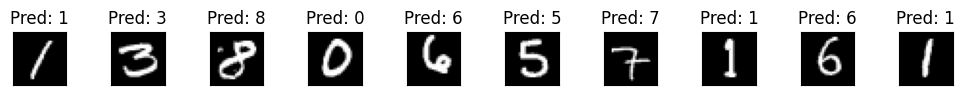

In [25]:
visualize(model, 10)